# Part 2b: Advanced Design Space Exploration

In this notebook, we will leverage Python programming to scan the design space of our HLS model.

## Setup

As we did in the previous notebooks, let's import the libraries, call the magic functions, and setup the environment variables.

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import hls4ml

%matplotlib inline

import os
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


### Load the dataset and the model

In [Part 1](part1_getting_started.ipynb), we saved the preprocessed dataset and model to files. Let's load them.

In [2]:
# Load dataset
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

# Load Keras model
from tensorflow.keras.models import load_model
model = load_model('model_1/KERAS_check_best_model.h5')
y_keras = model.predict(X_test)

## DSE

Let's combine everything together Python programming and `Precision` and `Reuse Factor` knobs.

First we encapsulate in a function the creation of a hls4ml configuration dictionary and hls4ml model creation, compilation and built (C-synthesis).

In [3]:
import time
import multiprocessing


def process_hls4ml(model, fxd_w, fxd_i, rf, dse_hls_results):
    # Generate a hls4ml configuration dictionary from the Keras model
    config = hls4ml.utils.config_from_keras_model(model, granularity='Model')
    # Update the knobs
    config['Model']['ReuseFactor'] = rf
    config['Model']['Precision'] = 'ap_fixed<' + str(fxd_w) + ',' + str(fxd_i) + '>'
    
    # Create an HLS model from the Keras model and the updated hls4ml configuration dictionary
    hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                           hls_config=config,
                                                           output_dir='model_1/hls4ml_prj_rf' + str(rf),
                                                           #fpga_part='xczu7ev-ffvc1156-2-e') # ZCU106
                                                           fpga_part='xczu3eg-sbva484-1-e') # Ultra96
                                                           #fpga_part='xc7z007sclg225-1') # MiniZed
    _ = hls_model.compile()

    start_time = time.time()
    hls_results = hls_model.build(csim=False)
    exec_time = time.time() - start_time

    hls_results["Execution Time"] = exec_time
    hls_results["W-bits FixedPoint"] = fxd_w
    hls_results["I-bits FixedPoint"] = fxd_i
    dse_hls_results[rf] = hls_results    

Use `multiprocessing` package to run multiple synthesis runs in parallel.

In [4]:
%%time

# Explore the Cartesian product of ReuseFactor and Precision
reuse_factor_values = [1, 2, 4, 8, 16]
fxd_w_values = [16]
fxd_i_values = [6]

# Append here the processes
processes = list()

# DSE results shared among processes
manager = multiprocessing.Manager()
dse_hls_results = manager.dict()

# Swipe over the Precision and ReuseFactor values and spawn synthesis processes
for fxd_w in fxd_w_values:
    for fxd_i in fxd_i_values:
        for rf in reuse_factor_values:
            t = multiprocessing.Process(target=process_hls4ml, args=(model, fxd_w, fxd_i, rf, dse_hls_results))
            processes.append(t)
            t.start()

# Wait for completion
for t in processes:
    t.join()

CPU times: user 38 ms, sys: 96.2 ms, total: 134 ms
Wall time: 15min 26s


Print DSE results on console.

In [5]:
def print_hls_results(hls_results):
    print('-----------------------------------')
    #print(hls_results) # Print hashmap
    print("Fixed-Point Word Size: {}".format(hls_results['W-bits FixedPoint']))
    print("Fixed-Point Integer-Part Size: {}".format(hls_results['I-bits FixedPoint']))
    print("Execution Time: {} s".format(hls_results['Execution Time']))
    print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
    print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
    print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
    print("BRAM_18K:               {} (Aval. {})".format(hls_results['BRAM_18K'], hls_results['AvailableBRAM_18K']))
    print("DSP48E:                 {} (Aval. {})".format(hls_results['DSP48E'], hls_results['AvailableDSP48E']))
    print("FF:                     {} (Aval. {})".format(hls_results['FF'], hls_results['AvailableFF']))
    print("LUT:                    {} (Aval. {})".format(hls_results['LUT'], hls_results['AvailableLUT']))
    print("URAM:                   {} (Aval. {})".format(hls_results['URAM'], hls_results['AvailableURAM']))
    print('-----------------------------------')

for rf in dse_hls_results.keys():
    print_hls_results(dse_hls_results[rf])

-----------------------------------
Fixed-Point Word Size: 16
Fixed-Point Integer-Part Size: 6
Execution Time: 828.92884349823 s
Estimated Clock Period: 5.101 ns
Best/Worst Latency:     78 / 78
Interval Min/Max:       16 / 16
BRAM_18K:               2 (Aval. 432)
DSP48E:                 271 (Aval. 360)
FF:                     65059 (Aval. 141120)
LUT:                    115654 (Aval. 70560)
URAM:                   0 (Aval. 0)
-----------------------------------
-----------------------------------
Fixed-Point Word Size: 16
Fixed-Point Integer-Part Size: 6
Execution Time: 860.2303986549377 s
Estimated Clock Period: 5.391 ns
Best/Worst Latency:     28 / 28
Interval Min/Max:       4 / 4
BRAM_18K:               2 (Aval. 432)
DSP48E:                 1069 (Aval. 360)
FF:                     57662 (Aval. 141120)
LUT:                    130581 (Aval. 70560)
URAM:                   0 (Aval. 0)
-----------------------------------
-----------------------------------
Fixed-Point Word Size: 16
Fixed

Define a plot 2D function.

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np


def plot_hls_results(dse_hls_results, resource_label, show_values=False, show_precision=True):
    reuse_factor_x_axis = np.array(list(dse_hls_results.keys()))
    resource_usage_y_axis = []
    fxd_w_precision = []
    fxd_i_precision = []
    resource_available_y_axis=[]
    for i, d in dse_hls_results.items():
        resource_usage_y_axis.append(int(dse_hls_results[i][resource_label]))
    for i, d in dse_hls_results.items():
        resource_available_y_axis.append(int(dse_hls_results[i]['Available' + resource_label]))
    for i, d in dse_hls_results.items():
        fxd_w_precision.append(int(dse_hls_results[i]['W-bits FixedPoint']))
    for i, d in dse_hls_results.items():
        fxd_i_precision.append(int(dse_hls_results[i]['I-bits FixedPoint']))
    
    fig, ax = plt.subplots()
    ax.set_xlabel('Reuse Factor')
    ax.set_ylabel(resource_label + ' (HLS Estimates)')

    ax.plot(reuse_factor_x_axis, resource_usage_y_axis, linestyle='--', marker='o')

    ax.axhline(y=resource_available_y_axis[0], color='r', linestyle='-', label = resource_label + ' (Available)')
    ax.set_xticks((reuse_factor_x_axis))
    
    ax.grid(True)

    ax.legend(loc='upper right')
    plt.figtext(0.90, 0.90,'hls4ml',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    
    if show_values:
        for x,y in zip(reuse_factor_x_axis,resource_usage_y_axis):
            label = "{:d}".format(y)
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    if show_precision:
        for x,y,w,i in zip(reuse_factor_x_axis,resource_usage_y_axis,fxd_w_precision,fxd_i_precision):
            label = '<{},{}>'.format(w,i)
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

Plot some of the resources from the previous DSE.

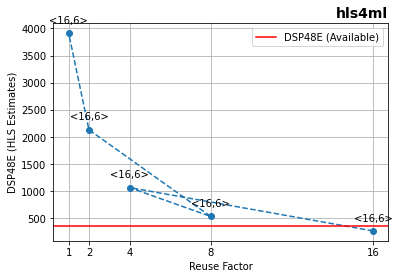

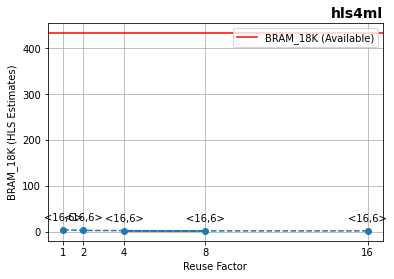

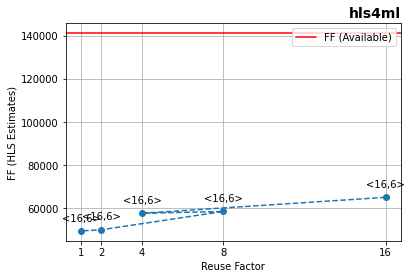

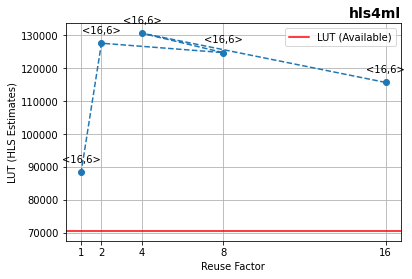

In [7]:
plot_hls_results(dse_hls_results, 'DSP48E')
plot_hls_results(dse_hls_results, 'BRAM_18K')
plot_hls_results(dse_hls_results, 'FF')
plot_hls_results(dse_hls_results, 'LUT')

Save DSE results on file for future reference.

In [8]:
import json
json = json.dumps(dse_hls_results)
f = open("dse_hls_results.json","w")
f.write(json)
f.close()

TypeError: Object of type DictProxy is not JSON serializable

Load DSE results from file.

In [ ]:
import json 

with open('dse_hls_results.json') as json_file: 
    data = json.load(json_file) 
  
    # Print the type of data variable 
    print(data['1'])

## Exercises

- Use `Pool` Python package to allocate a number of synthesis non bigger than the number of CPU cores/threads.
- DSE at the same time over `Precision` and `ReuseFactor`.
- 3D plotting (?)